In [37]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
df = pd.read_excel('/home/muregz/data_analysis/mpesa_statement_analysis/mpesa_statement.ods')
df.head(10)

,Receipt No.,Completion Time,Details,Transaction Status,Paid In,Withdrawn,Balance
0,REF8MUC88I,2023-05-15 20:19:22,Customer Transfer Fuliza MPesato - 07******212...,Completed,NaN,-50,0
1,REF8MUC88I,2023-05-15 20:19:22,OverDraft of Credit Party,Completed,50,NaN,50
2,REF9MU2IWF,2023-05-15 20:17:21,Merchant Payment Fuliza M-Pesato 7384394 - DAM...,Completed,NaN,-30,0
3,REF9MU2IWF,2023-05-15 20:17:21,OverDraft of Credit Party,Completed,30,NaN,30
4,REF7MT5G7N,2023-05-15 20:10:35,Customer Transfer Fuliza MPesato - 2547******5...,Completed,NaN,-10,0
5,REF7MT5G7N,2023-05-15 20:10:35,OverDraft of Credit Party,Completed,10,NaN,10
6,REF6MSH7KM,2023-05-15 20:05:47,Merchant Payment Fuliza M-Pesato 671957 - FISH...,Completed,NaN,-70,0
7,REF6MSH7KM,2023-05-15 20:05:47,OverDraft of Credit Party,Completed,70,NaN,70
8,REF5MQQC5T,2023-05-15 19:53:32,OD Loan Repayment to 232323 -M-PESA Overdraw,Completed,NaN,-150,0
9,REF0MQQ2C2,2023-05-15 19:53:32,Funds received from -07******440 diana mugwe,Completed,150,NaN,150


In [39]:
#checking if there are any null values in the dataset
df.isna().sum()

Receipt No.            346
Completion Time        347
Details                349
Transaction Status     348
Paid In               2550
Withdrawn             1781
Balance                348
dtype: int64

In [40]:
#checking the datatypes in the dataframe
df.dtypes

Receipt No.           object
Completion Time       object
Details               object
Transaction Status    object
Paid In               object
Withdrawn             object
Balance               object
dtype: object

In [41]:
#showing the total received amount
df['Paid In'] = pd.to_numeric(df['Paid In'], errors='coerce')

# Calculate the sum of the 'Paid In' column
total_received = df['Paid In'].sum()

print('{:,.2f}'.format(total_received))

468,474.82


In [42]:
#showing the total amount spent
df['Withdrawn'] = pd.to_numeric(df['Withdrawn'], errors='coerce')

#calculatiing the sum of the withdrawn column
total_spent = df['Withdrawn'].sum()

print('{:,.2f}'.format(abs(total_spent)))

468,381.71


In [43]:
#showing the highest amount received
highest_amount_row = df[df['Paid In'] == df['Paid In'].max()]
highest_amount_details = highest_amount_row[['Details', 'Paid In']]
print(highest_amount_details)


                                                Details  Paid In
3768  Receive International TransferFrom 339888 - CH...  21046.0


In [44]:
#showing the highest amount spent
highest_spent_row = df[df['Withdrawn']  == df['Withdrawn'].min()]
highest_spent_details = highest_spent_row[['Details', 'Withdrawn']]
print(highest_spent_details)

                                                Details  Withdrawn
3697  Pay Bill Fuliza M-Pesa to 100205- CUEA via Cit...   -20790.0


In [45]:
df

,Receipt No.,Completion Time,Details,Transaction Status,Paid In,Withdrawn,Balance
0,REF8MUC88I,2023-05-15 20:19:22,Customer Transfer Fuliza MPesato - 07******212...,Completed,NaN,-50.00,0
1,REF8MUC88I,2023-05-15 20:19:22,OverDraft of Credit Party,Completed,50.0,NaN,50
2,REF9MU2IWF,2023-05-15 20:17:21,Merchant Payment Fuliza M-Pesato 7384394 - DAM...,Completed,NaN,-30.00,0
3,REF9MU2IWF,2023-05-15 20:17:21,OverDraft of Credit Party,Completed,30.0,NaN,30
4,REF7MT5G7N,2023-05-15 20:10:35,Customer Transfer Fuliza MPesato - 2547******5...,Completed,NaN,-10.00,0
...,...,...,...,...,...,...,...
3982,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3983,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3984,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3985,QEG03RDEQM,2022-05-16 12:52:30,OD Loan Repayment to 232323 -M-PESA Overdraw,Completed,NaN,-480.37,569.63


In [46]:
# Pivot the DataFrame to keep only selected columns
df_pivoted = df[['Completion Time', 'Details', 'Paid In', 'Withdrawn']]

In [47]:
df_pivoted.head(10)

,Completion Time,Details,Paid In,Withdrawn
0,2023-05-15 20:19:22,Customer Transfer Fuliza MPesato - 07******212...,NaN,-50.0
1,2023-05-15 20:19:22,OverDraft of Credit Party,50.0,NaN
2,2023-05-15 20:17:21,Merchant Payment Fuliza M-Pesato 7384394 - DAM...,NaN,-30.0
3,2023-05-15 20:17:21,OverDraft of Credit Party,30.0,NaN
4,2023-05-15 20:10:35,Customer Transfer Fuliza MPesato - 2547******5...,NaN,-10.0
5,2023-05-15 20:10:35,OverDraft of Credit Party,10.0,NaN
6,2023-05-15 20:05:47,Merchant Payment Fuliza M-Pesato 671957 - FISH...,NaN,-70.0
7,2023-05-15 20:05:47,OverDraft of Credit Party,70.0,NaN
8,2023-05-15 19:53:32,OD Loan Repayment to 232323 -M-PESA Overdraw,NaN,-150.0
9,2023-05-15 19:53:32,Funds received from -07******440 diana mugwe,150.0,NaN


In [48]:
# Filter out rows with non-parsable 'Completion Time' values
df_pivoted = df_pivoted[df_pivoted['Completion Time'].str.match(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}', na=False)]

# Convert 'Completion Time' to datetime
df_pivoted['Completion Time'] = pd.to_datetime(df_pivoted['Completion Time'], format='%Y-%m-%d %H:%M:%S')

# Create the 'Transaction Month' column
df_pivoted['Transaction Month'] = df_pivoted['Completion Time'].dt.strftime('%B')


In [49]:
df_pivoted

,Completion Time,Details,Paid In,Withdrawn,Transaction Month
0,2023-05-15 20:19:22,Customer Transfer Fuliza MPesato - 07******212...,NaN,-50.00,May
1,2023-05-15 20:19:22,OverDraft of Credit Party,50.00,NaN,May
2,2023-05-15 20:17:21,Merchant Payment Fuliza M-Pesato 7384394 - DAM...,NaN,-30.00,May
3,2023-05-15 20:17:21,OverDraft of Credit Party,30.00,NaN,May
4,2023-05-15 20:10:35,Customer Transfer Fuliza MPesato - 2547******5...,NaN,-10.00,May
...,...,...,...,...,...
3978,2022-05-16 14:19:25,Customer Transfer of FundsCharge,NaN,-12.00,May
3979,2022-05-16 14:19:25,Customer Transfer Fuliza MPesato - 2547******6...,NaN,-850.00,May
3980,2022-05-16 14:19:25,OverDraft of Credit Party,292.37,NaN,May
3985,2022-05-16 12:52:30,OD Loan Repayment to 232323 -M-PESA Overdraw,NaN,-480.37,May


In [50]:
# Group by 'Transaction Month' and sum the 'Withdrawn' values, and assign it to a new column 'Monthly Total'
df_pivoted['Monthly Total'] = df_pivoted.groupby('Transaction Month')['Withdrawn'].transform(lambda x: x.abs().sum())


/home/muregz/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/muregz/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/muregz/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/muregz/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating inste

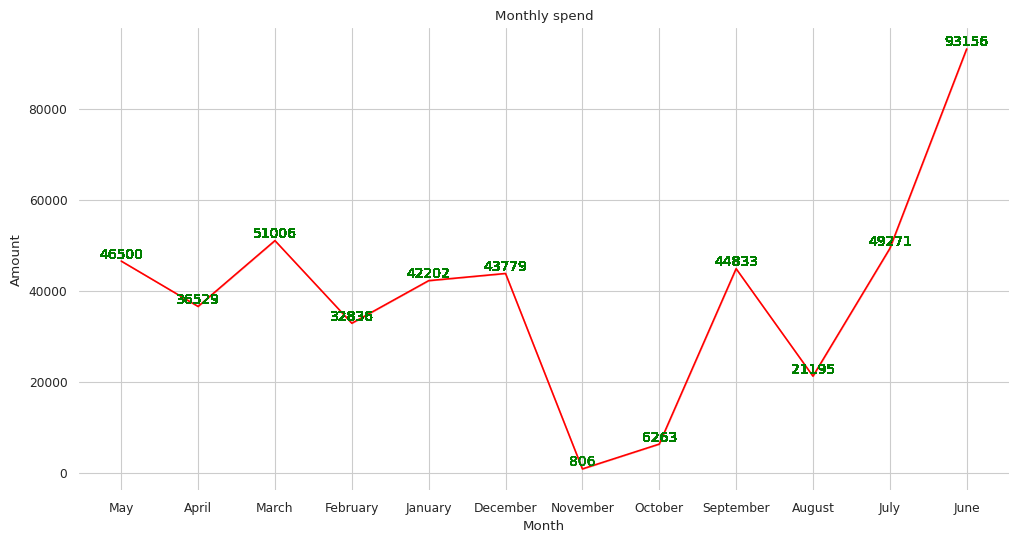

In [51]:
Color = 'red'

plt.figure(figsize=(12,6))

#plotting the data
ax = sns.lineplot(x='Transaction Month', y='Monthly Total', data=df_pivoted, color='red')

# annotating the line plot
for i, row in df_pivoted.iterrows():
    plt.text(row['Transaction Month'], row['Monthly Total'], str(int(row['Monthly Total'])),
             ha='center', va='bottom', fontsize=10, color='Green')
    

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)



sns.despine(left=True, right=True, top=True, bottom=True)
sns.set_style('whitegrid')
sns.set_context('paper')

plt.title('Monthly spend')
plt.xlabel('Month')
plt.ylabel('Amount')

plt.show()

Haven't changed the month order because the dataset is from June 2022 to May 2023

In [73]:
#calculating the amount of money spent on electricity

#extracting rows where 'Details contains the word 'KPLC'
electricity_keyword = 'KPLC'
filtered_df = df_pivoted[df_pivoted['Details'].str.contains(electricity_keyword, case=False, na=False)]

electricity = abs(filtered_df['Withdrawn'].sum())

print(f'Amount used to Purchase Electricity: {electricity:.2f}')


Amount used to Purchase Electricity: 614.00


In [72]:
#calculating the amount of money spent on rent

#extracting rows where 'Details" contains the word 'raymond mbuvi'
rent_keyword = ['Raymond Mbuvi', 'Cosmic', 'Pay Bill to 247247 - Equity Paybill Account Acc.0300196339189']
filtered_df = df_pivoted[df_pivoted['Details'].str.contains('|'.join(rent_keyword), case=False, na=False)]

rent = abs(filtered_df['Withdrawn'].sum())
print(f'Amount used to Pay Rent: {rent:,.2f}')

Amount used to Pay Rent: 43,600.00


In [71]:
#calculating the amount used to buy airtime
airtime_keyword = 'Airtime'

filtered_df = df_pivoted[df_pivoted['Details'].str.contains(airtime_keyword, case=False, na=False)]

airtime = abs(filtered_df['Withdrawn'].sum())

print(f'Amount used to Purchase Airtime: {airtime:,.2f}')

Amount used to Purchase Airtime: 3,318.00


In [74]:
#calculating the amount used to buy drugs
drugs_keyword = ['Bar', 'Kapbrandy', 'Onsare', 'wines', 'Simba', 'Tamasha', 'pub', 'Maina', 'Muganda', 'Wambwa']
filtered_df = df_pivoted[df_pivoted['Details'].str.contains('|'.join(drugs_keyword), case=False, na=False)]

drugs = abs(filtered_df['Withdrawn'].sum())
print(f'Amount used to buy drugs: {drugs:,.2f}')


#calculating the amount used to buy drugs')

Amount used to buy drugs: 55,745.00


In [75]:
#calculating the amount of money used to repay fuliza
fuliza_keyword = 'Fuliza'

filtered_df = df_pivoted[df_pivoted['Details'].str.contains(fuliza_keyword, case=False, na=False)]

fuliza = abs(filtered_df['Withdrawn'].sum())
print(f'Amount used to Repay Fuliza: {fuliza:,.2f}')

Amount used to Repay Fuliza: 104,549.00


In [76]:
#calculating the amount of money withdrawn from an mpesa agent
withdrawn_keyword = 'Customer Withdrawal At Agent'

filtered_df = df_pivoted[df_pivoted['Details'].str.contains(withdrawn_keyword, case=False, na=False)]

withdrawn_amount = abs(filtered_df['Withdrawn'].sum())
print(f'Withdrawn amount: {withdrawn_amount:,.2f}')

Withdrawn amount: 8,700.00


In [77]:
#calculating the amount of money transacted through lipa na mpesa
lipa_keyword = ['Merchant Payment', 'Pay Bill to', 'Customer Payment to', 'Pay Bill Online to']

filtered_df = df_pivoted[df_pivoted['Details'].str.contains('|'.join(lipa_keyword), case=False, na=False)]

lipa_na_mpesa = abs(filtered_df['Withdrawn'].sum())
print(f'Amount Transacted using Lipa na Mpesa: {lipa_na_mpesa:,.2f}')

Amount Transacted using Lipa na Mpesa: 146,451.00


In [78]:
#calculating the paybbill charge for the above transactions
charge_keyword = 'Pay bill Charge'

filtered_df = df_pivoted[df_pivoted['Details'].str.contains(charge_keyword, case=False, na=False)]

paybill_charge = abs(filtered_df['Withdrawn'].sum())
print(f'Pay Bill Charge: {paybill_charge:,.2f}')

Pay Bill Charge: 772.00


In [79]:
#calculating the amount of money transacted using send money
send_keyword = 'Customer Transfer to'

filtered_df = df_pivoted[df_pivoted['Details'].str.contains(send_keyword, case=False, na=False)]

send_money = abs(filtered_df['Withdrawn'].sum())
print(f'Money Sent: {send_money:,.2f}')

Money Sent: 100,005.00


In [84]:
#calculating the total amount charged for transacting using send money
send_charge_keyword = 'Customer Transfer of Funds'

filtered_df = df_pivoted[df_pivoted['Details'].str.contains(send_charge_keyword, case=False, na=False)]

send_money_charge = abs(filtered_df['Withdrawn'].sum())

print(f'Total Transaction fees charged for Send Money: {send_money_charge:,.2f}')

Total Transaction fees charged for Send Money: 1,722.00


In [86]:
#calculating the total amount received via send money
received_keyword = 'Funds received from'

filtered_df = df_pivoted[df_pivoted['Details'].str.contains(received_keyword, case=False, na=False)]

total_received = filtered_df['Paid In'].sum()

print(f'Total Amount received via Send Money {total_received:,.2f}')

Total Amount received via Send Money 126,337.00


In [89]:
#calculating the total amount received via international transfer
received_international_keyword = ['sendwave', 'chime']

filtered_df = df_pivoted[df_pivoted['Details'].str.contains('|'.join(received_international_keyword), case=False, na=False)]
international_transfer = filtered_df['Paid In'].sum()

print('Total amount received via international transfer: {:,.2f}'.format(international_transfer))

Total amount received via international transfer: 186,395.00
